In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#load_dir = './CVPR/final/facial_recognition'
load_dir = 'C:/CVPR/final/facial_recognition'

pickle_in = open(os.path.join(load_dir, "categories.pickle"), "rb")
categories = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_train.pickle"), "rb")
X_train = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_train.pickle"), "rb")
y_train = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_valid.pickle"), "rb")
X_valid = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_valid.pickle"), "rb")
y_valid = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_test.pickle"), "rb")
X_test = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_test.pickle"), "rb")
y_test = pickle.load(pickle_in)

In [3]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense , Dropout , BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
input_tensor = Input(shape=(256, 256, 3))

base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)


In [6]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.8)(x)  # Increased dropout rate to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)  # Additional dropout layer
predictions = Dense(32, activation='softmax')(x)


In [7]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0004), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_mobilenet_model.h5', monitor='val_accuracy', save_best_only=True)

In [8]:
EPOCHS = 150  # Increased number of epochs

# Fit the model using the data generator for augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Using data augmentation
    validation_data=(X_valid, y_valid),  # Validation data
    epochs=EPOCHS,  # Define the number of epochs as required
    verbose=1,  # Display progress during training
    callbacks=[early_stopping, model_checkpoint]  # Use callbacks
)

Epoch 1/150
6/6 [==============================] - 4s 239ms/step - loss: 5.1182 - accuracy: 0.0430 - val_loss: 3.8182 - val_accuracy: 0.0303
Epoch 2/150
6/6 [==============================] - 1s 243ms/step - loss: 4.3553 - accuracy: 0.0806 - val_loss: 4.1132 - val_accuracy: 0.0606
Epoch 3/150
6/6 [==============================] - 1s 175ms/step - loss: 3.9518 - accuracy: 0.0753 - val_loss: 4.4728 - val_accuracy: 0.0303
Epoch 4/150
6/6 [==============================] - 1s 167ms/step - loss: 3.5319 - accuracy: 0.1290 - val_loss: 4.5831 - val_accuracy: 0.0303
Epoch 5/150
6/6 [==============================] - 1s 169ms/step - loss: 3.0809 - accuracy: 0.2312 - val_loss: 4.1839 - val_accuracy: 0.0606
Epoch 6/150
6/6 [==============================] - 1s 232ms/step - loss: 2.7717 - accuracy: 0.2581 - val_loss: 3.8267 - val_accuracy: 0.1818
Epoch 7/150
6/6 [==============================] - 1s 217ms/step - loss: 2.6777 - accuracy: 0.2957 - val_loss: 3.6604 - val_accuracy: 0.2424
Epoch 8/150
6

In [9]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

2/2 [==============================] - 0s 4ms/step - loss: 0.9643 - accuracy: 0.8485
Validation Loss: 0.9643176198005676
Validation Accuracy: 0.8484848737716675


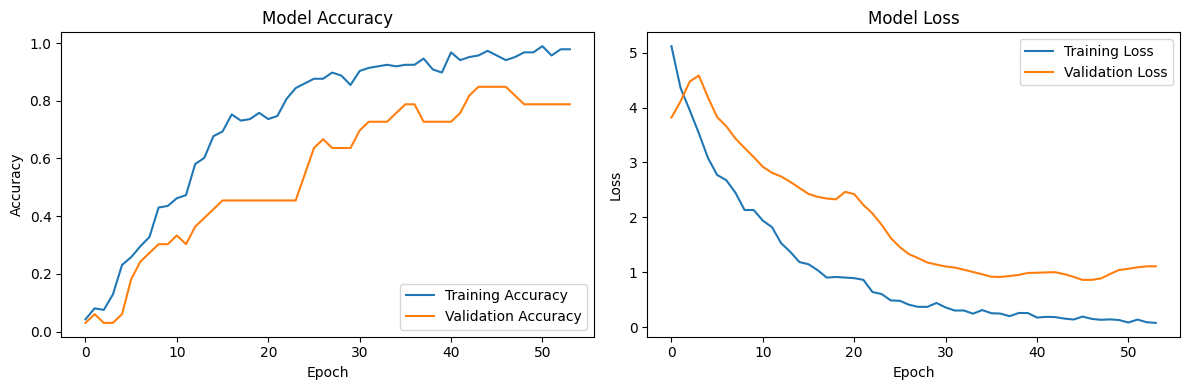

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 [==============================] - 0s 16ms/step - loss: 0.9670 - accuracy: 0.7912
Test Loss: 0.9670491218566895
Test Accuracy: 0.791208803653717


In [12]:
predictions = model.predict(X_test)

3/3 [==============================] - 0s 15ms/step


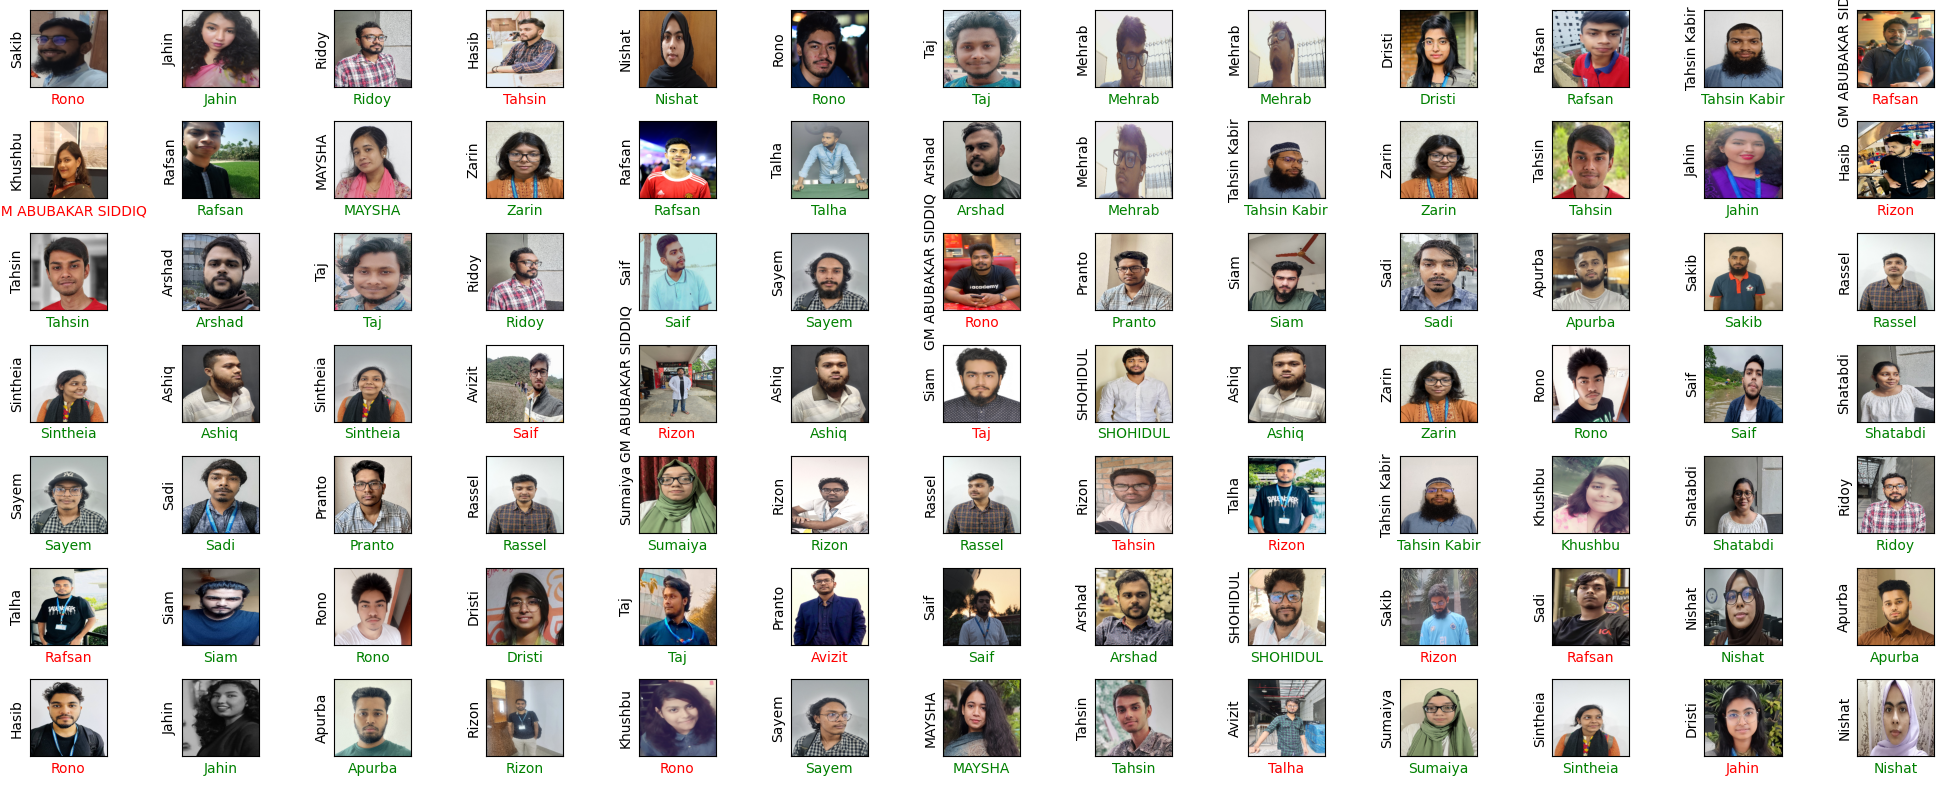

In [13]:
# Visualize the predictions
plt.figure(figsize=(20, 10))
for i in range(len(X_test)):
    plt.subplot(9, 13, i + 1)
    plt.imshow(X_test[i].astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(categories[y_test[i]])
    # Check if the predicted label matches the true label
    if y_test[i] == np.argmax(predictions[i]):
        plt.xlabel(categories[np.argmax(predictions[i])], color='g')  # Correct prediction in green
    else:
        plt.xlabel(categories[np.argmax(predictions[i])], color='r')  # Incorrect prediction in red

plt.tight_layout()
plt.show()

In [16]:
model_path = 'C:/CVPR/final/facial_recognition'

model.save(os.path.join(model_path, "testv1.h5"))